<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Performance Monitoring on a Binary Classification Model</h1>

**Dataset and ML model**: In this example, we train a binary classifier on a popular network traffic dataset called the [NSL-KDD dataset](https://www.unb.ca/cic/datasets/nsl.html) for cyber-attack classification using the [XGBoost classifier](https://xgboost.readthedocs.io/en/stable/). 

**Problem**: Once we train the cyber-attack classification model, it performs well initially, but later, the attackers catch up and change their manner of attacks, which causes our model predictions to go wrong. 

**Solution**: Use the UpTrain framework to indentify the drift in model predictions (aka concept drift).

In [1]:
import os
import subprocess
import time

### Install required packages for this example

In [2]:
!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import uptrain
from xgboost import XGBClassifier

First, we download the preprocessed NSL-KDD dataset (if not already exists). 

In [4]:
data_file = "NSL_KDD_binary.csv"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/NSL_KDD_binary.csv"
if not os.path.exists(data_file):
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
    except:
        print("Could not load training data")
else:
    print("Data file exists. Skipping download.")

Data file exists. Skipping download.


### Read the training and test set

In [5]:
df = pd.read_csv(data_file)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Divide the data into training and test sets
We use first 10% of the data to train and 90% of the data to evaluate the model in production

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.1, 
                                                    test_size = 0.9, 
                                                    random_state = 0,
                                                    shuffle=False)

### Step 1: Train our XGBoost Classifier

In [7]:
# Train the XGBoost classifier with training data
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_train)
print("Training accuracy: " + str(100*accuracy_score(y_train, y_pred)))

Training accuracy: 100.0


Woah! 😲🔥 The training accuracy is 100%. Let's see how long the model lasts in production. 

## Identifying Concept Drift

In this example, we implement two methods to identify concep drift:
1. Use the popular concept drift detectection algorithm for binary tasks called the [Drift Detection Method (DDM)](https://riverml.xyz/dev/api/drift/DDM/). DDM is implemented as a part of the UpTrain package.
2. A custom drift metric that is defined by the user below. Specifically, the user wants to monitor the difference between accuracy of the model on the first 200 predictions and the most recent 200 predictions. This way, they can quickly identify if there was a sudden degradation in the model performance.

### Step 2: Defining a Custom Monitor on the initial and most recent performance of the model

In [8]:
"""
Defining a custom drift metric where
the user just want to check if accuracy 
drops beyond a threshold.
"""

def custom_initialize_func(self):
    self.initial_acc = None       
    self.acc_arr = []
    self.count = 0       
    self.thres = 0.02
    self.window_size = 200
    self.is_drift_detected = False

def custom_check_func(self, inputs, outputs, gts=None, extra_args={}):
    batch_size = len(extra_args["id"])
    self.count += batch_size
    self.acc_arr.extend(list(np.equal(gts, outputs)))
    
    # Calculate initial performance of the model on first 200 points
    if (self.count >= self.window_size) and (self.initial_acc is None):
        self.initial_acc = sum(self.acc_arr[0:self.window_size])/self.window_size
        
    # Calculate the most recent accuracy and log it to dashboard.
    if (self.initial_acc is not None):
        for i in range(self.count - batch_size, self.count, self.window_size):
            
            # Calculate the most recent accuracy
            recent_acc = sum(self.acc_arr[i:i+self.window_size])/self.window_size
            
            # Logging to UpTrain dashboard
            self.log_handler.add_scalars('custom_metrics', {
                    'initial_acc': self.initial_acc,
                    'recent_acc': recent_acc,
                }, i, self.dashboard_name)
            
            # Print a message when recent model performance goes down 
            if (self.initial_acc - recent_acc > self.thres) and (not self.is_drift_detected):
                    print("Concept drift detected with custom metric at time: ", i)
                    self.is_drift_detected = True

### Step 3: Define the list of checks to perform on model
Here, we have two checks: concept drfit check with DDM algorithm and the customized check from above

In [9]:
checks = [
    {
    'type': uptrain.Anomaly.CONCEPT_DRIFT,
    'algorithm': uptrain.DataDriftAlgo.DDM,
    'warn_thres': 2,
    'alarm_thres': 3,
    },
    {
    'type': uptrain.Anomaly.CUSTOM_MONITOR,
    'initialize_func': custom_initialize_func,
    'check_func': custom_check_func,
    'need_gt': True,
    },
]

### Step 4: Define config and initialize the UpTrain framework

In [10]:
cfg = {
    # Checks to identify concept drift
    "checks": checks,
    
    # Folder that stores data logged by UpTrain
    "retraining_folder": 'uptrain_smart_data',
    
    # Enable streamlit logging
    # Note: Requires streamlit to be installed 
    "st_logging": True,
}

# Initialize the UpTrain framework
framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.6.64:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


### Step 5: Deploy the model in production and wait for alerts!

In [11]:
batch_size = 10000
all_ids = []
for i in range(int(len(X_test)/batch_size)):
    
    # Do model prediction
    inputs = {'data': {"feats": X_test[i*batch_size:(i+1)*batch_size]}}
    preds = classifier.predict(inputs['data']["feats"])
    
    # Log model inputs and outputs to monitor concept drift
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Attach ground truth to corresponding predictions 
    # in UpTrain framewrok and identify concept drift
    ground_truth = y_test[i*batch_size:(i+1)*batch_size] 
    framework.log(identifiers=ids, gts = ground_truth)
    
    # Pausing between batches to monitor progress in the dashboard
    time.sleep(2)

Drift detected with DDM at time:  111298
Concept drift detected with custom metric at time:  111000


As can be noted from above, our two drift monitors predict a drift around the timestamp of 111k

### Verification of drifts with the UpTrain dashboard

The UpTrain framework automatically logs important metrics such as accuracy for the user to observe the performance of their models. The dashboard is currently integrated with **streamlit** and is launched automatically if *st_logging* is enables in streamlit.

### Accuracy versus num_predictions

The following is a screenshot of average accuracy versus time from the dashboard. We can observe a data drift around the timestamp of 111k, which is also predicted by our drift monitors.

<!-- 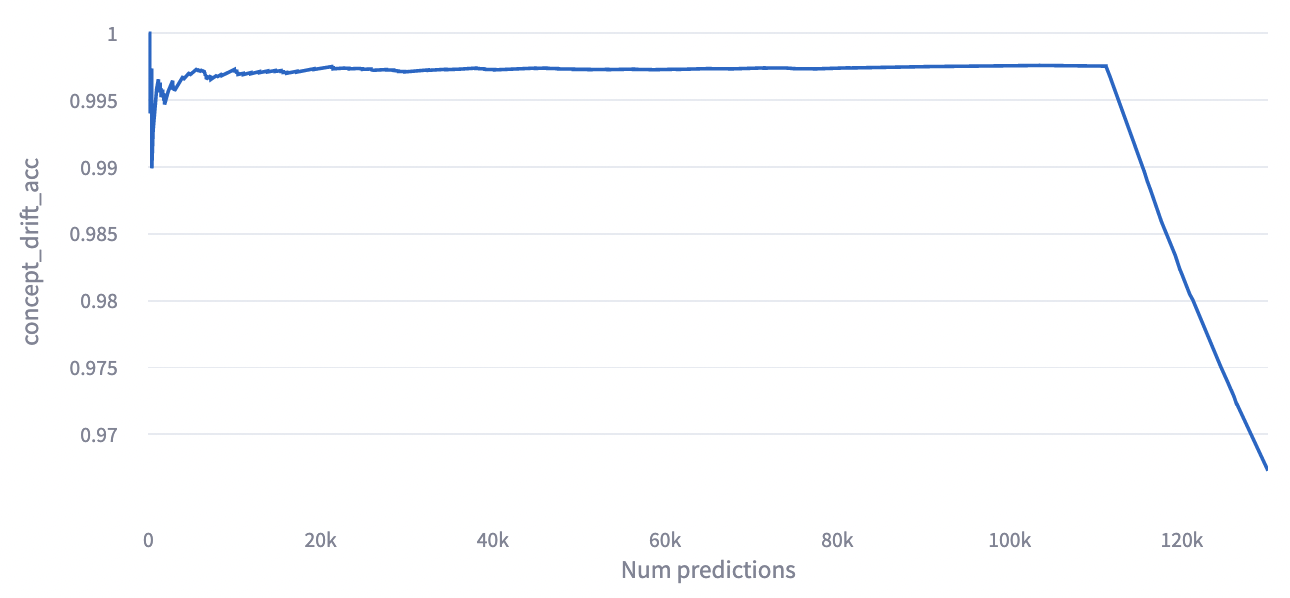 -->
<div>
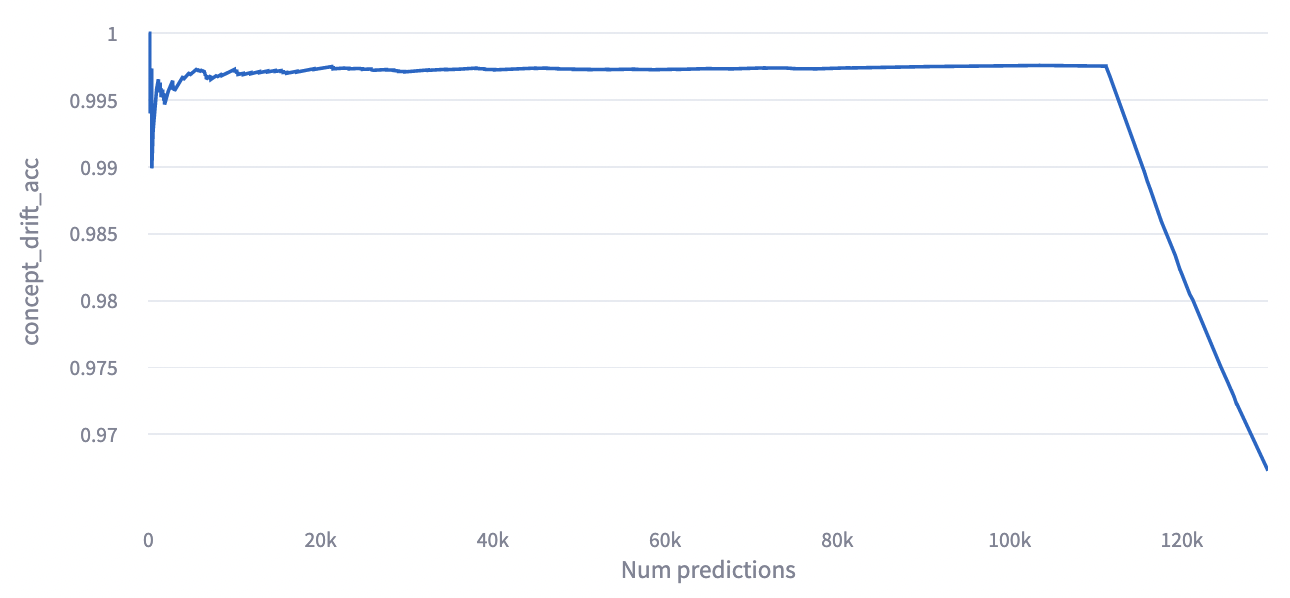
</div>

### Custom Monitor

Finally, the users can also plot the customized metrics we defined earlier, which in this case were the initial accuracy of the model and the most recent accuracy.

<div>
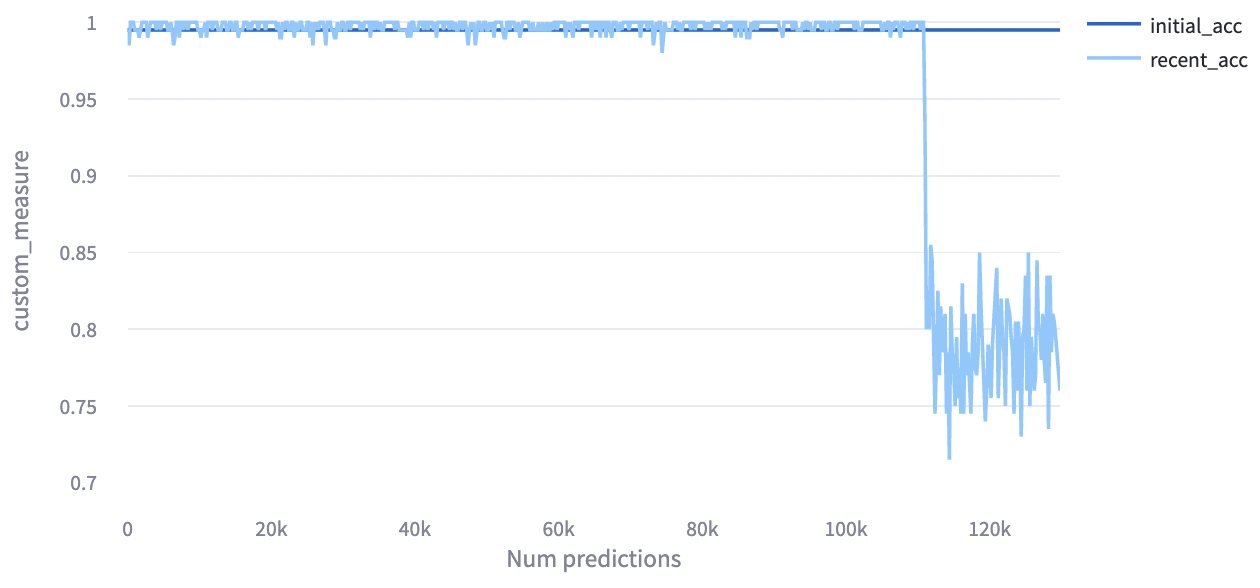
</div>

Observe how the most **recent accuracy** of the model is **far lower** than the **initial accuracy**, implying that the attackers have learned to fool the model.